# Fine-Tuning of a base ViT

In [1]:
!pip install medmnist
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.6 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [2]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests
from medmnist import OCTMNIST, PathMNIST
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

In [ ]:
train_dataset = OCTMNIST(split="train", download=True)

100%|██████████| 54.9M/54.9M [00:05<00:00, 10.4MB/s]


In [ ]:
train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, array([0]))

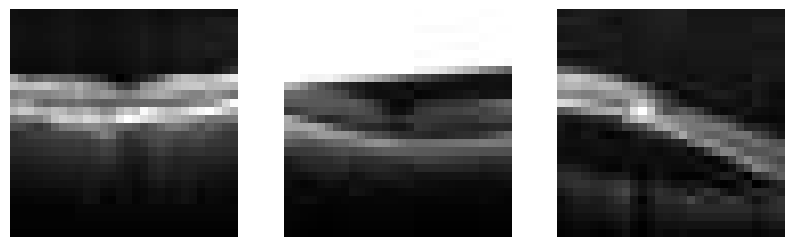

In [ ]:
rows, cols = 1, 3
figure = plt.figure(figsize=(10, 10))
for i in range(1, cols * rows + 1):

    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]

    img_tensor = transforms.ToTensor()(img)

    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img_tensor.squeeze(), cmap="gray")

plt.show()

In [ ]:
from medmnist import INFO, Evaluator

pathmnist_info = INFO["pathmnist"]
labels = pathmnist_info["label"]

pathmnist_info

{'python_class': 'PathMNIST',
 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.',
 'url': 'https://zenodo.org/records/10519652/files/pathmnist.npz?download=1',
 'MD5': 'a8b06965200029087d5bd730944a56c1',
 'url_64': 'https://zenodo.org/records/10519652/files/pathmnist_64.npz?download=1',
 'MD5_64': '55aa9c1e0525abe5a6b9d8343a507616',
 'url_128': 'https://zenodo.org/records/10519652/files/pathmnist_128.npz?download=1',
 'MD5

In [ ]:
test_image = train_dataset[0][0]

test_image = test_image.convert('RGB')

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=test_image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()

print("Predicted class:", model.config.id2label[predicted_class_idx])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Predicted class: nematode, nematode worm, roundworm


Unsure if we need to apply `.convert('RGB')` or if there exist another way to use OCTMNIST images in the ViT model, because the model expects dimensions of images to be 3, but since OCTMNIST have grayscaled images, the dimension is 2.

# Data Preparation

In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
from transformers import ViTConfig, ViTModel, ViTForImageClassification
from medmnist import INFO, Evaluator

configuration = ViTConfig(image_size=28, num_labels=len(INFO["pathmnist"]['label']))
model = ViTForImageClassification(configuration)
configuration = model.config

configuration

ViTConfig {
  "_attn_implementation_autoset": true,
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "image_size": 28,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "transformers_version": "4.50.3"
}

In [4]:
# Important because we need a dict for fine-tuning
class CustomPathMNIST(PathMNIST):

  def __getitem__(self, idx):
    image, label = super().__getitem__(idx)
    item = {'pixel_values' : image, 'labels' : label}
    return item


currently testing for pathmnist images since they already have images of 3 dimensions

In [5]:
# Fix Memory on Colab (before relying on Pro tier memory)
from torch.utils.data import DataLoader

BATCH_SIZE = 64 # Changed from 64 to help use less GPU

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = CustomPathMNIST(split="train", transform=data_transform, size=28, download=True)
test_dataset = CustomPathMNIST(split="test", transform=data_transform, size=28, download=True)
val_dataset = CustomPathMNIST(split="val", transform=data_transform, size=28, download=True)


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 206M/206M [00:16<00:00, 12.6MB/s]


Feature batch shape: torch.Size([64, 3, 28, 28])
Labels batch shape: torch.Size([64, 1])
Label: tensor([4])


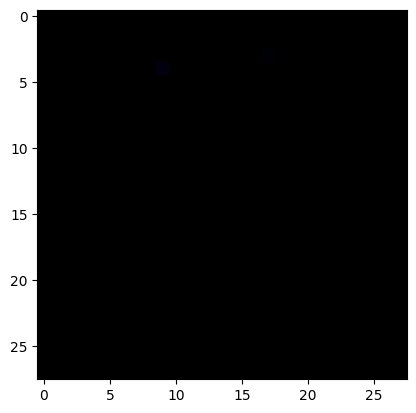

In [6]:
train_features = next(iter(train_dataloader))['pixel_values']
train_labels = next(iter(train_dataloader))['labels']

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

label = train_labels[0]
print(f"Label: {label}")


img = train_features[0].squeeze().permute(1,2,0)
plt.imshow(img)
plt.show()


In [ ]:
# Potential image normalization (same setup as preprocessing steps in ViT article)
# (e.g. reshape image to 224 x 224, or also keep the images 28x28 but change ViT shape to 28x28 instead)

In [ ]:
# Configure dataloaders/datasets to be in supported format for fine-tuning (fix error in trainer)

# Fine-Tuning

In [7]:
import numpy as np
from evaluate import load

metric = load("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
from transformers import TrainingArguments, Trainer

trainig_arguments = TrainingArguments(
    learning_rate = 3e-5,
    lr_scheduler_type="cosine",
    num_train_epochs=2,
    #fp16=True, # Try this or bf16 in case fine-tuning takes too much time
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_ratio = 0.2,
    save_strategy="epoch",
    #save_steps=10000,
    report_to="none"

)

In [9]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [10]:
trainer = Trainer(
    model=model,
    args=trainig_arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

train_results = trainer.train()

Step,Training Loss
500,2.081200
1000,1.780500
1500,1.688200
2000,1.613400
2500,1.519600
3000,1.547600
3500,1.491700
4000,1.498400
4500,1.425500
5000,1.467500


In [11]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         2.0
  total_flos               = 202627675GF
  train_loss               =      1.2108
  train_runtime            =  1:27:45.91
  train_samples_per_second =      34.181
  train_steps_per_second   =       17.09


In [12]:
metrics = trainer.evaluate(val_dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.6651
  eval_loss               =     1.0394
  eval_runtime            = 0:00:49.98
  eval_samples_per_second =    200.133
  eval_steps_per_second   =    100.067


In [21]:
test_dataset[0]['labels'].item()

8

In [29]:
def predict(idx):
  test_image = test_dataset[idx]['pixel_values'].to(model.device)

  outputs = model(test_image.unsqueeze(0))
  logits = outputs.logits

  predicted_class_idx = logits.argmax(-1).item()
  print("Predicted class:", model.config.id2label[predicted_class_idx])
  print("Real Class: ", f"LABEL_{test_dataset[idx]['labels'].item()}")

In [30]:
predict(0)

Predicted class: LABEL_8
Real Class:  LABEL_8


In [31]:
predict(200)

Predicted class: LABEL_0
Real Class:  LABEL_0


In [27]:
correct_predictions = 0

for idx in range(len(test_dataset)):
  image = test_dataset[idx]['pixel_values'].to(model.device)
  outputs = model(test_image.unsqueeze(0))
  logits = outputs.logits

  predicted_class_idx = logits.argmax(-1).item()

  if predicted_class_idx == test_dataset[idx]['labels'].item():
    correct_predictions += 1

print(f"Accuracy: {(correct_predictions / len(test_dataset))*100}%")

Accuracy: 18.635097493036213%


Reasonse explaining low accuracy :
  1. Fine-tuning arguments
  2. Fine-tuning on 28x28 images instead of 224x224

In [32]:
predict(150)

Predicted class: LABEL_2
Real Class:  LABEL_5
